## Import some python packages

In [1]:
%matplotlib inline
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import joblib  # For saving and loading model
import time

## Load the data

In [2]:
Xd = pickle.load(open("data/RML2016.10a_dict.pkl",'rb'),encoding = "bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

## Split the data into training and test sets

In [3]:
# Partition the data
#  into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

## Convert the dependent variables (labels) into one-hoe encoding format

In [4]:
#one-hot encoding the label
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [5]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


## Check the maximum and minimum values in both training and test sets

In [6]:
np.max(X_train), np.min(X_train)

(0.16046731, -0.15494554)

In [7]:
np.max(X_test), np.min(X_test)

(0.16422912, -0.15118897)

## Expand the input vector to 4D which can be fed into the CNN

In [8]:
# X_train = np.expand_dims(X_train, axis = 3)
# X_test = np.expand_dims(X_test, axis = 3)

In [9]:
# X_test.shape[1:]

## Performing principal component analysis (PCA)

In [10]:
# P_components = 100

# pca = PCA(n_components = P_components, whiten = True)

# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.fit_transform(X_test)

## Build the CNN model

In [11]:
model = models.Sequential()
# model.add(Reshape(in_shp+[1], input_shape=in_shp))  
model.add(Reshape(in_shp + [1], input_shape = in_shp))

# model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(16, (1, 16), activation ='relu'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (1, 2)))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(32, (2, 8), activation ='relu'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (1, 2)))
# model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Conv2D(64, (1, 4), activation ='relu'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (1, 2)))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.add(Conv2D(32, (1, 3), activation ='relu'))
# # model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size = (1, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv2D(64, (1, 1), activation ='relu'))
# # model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (1, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# # model.add(Conv2D(80, (1, 3)))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))
# # model.add(Activation('relu'))

# # model.add(Conv2D(80, (1, 3)))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))
# # model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size = (1, 2)))

# model.add(Conv2D(64, (1, 3), activation ='relu'))
# # model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv2D(64, (1, 3), activation ='relu'))
# # model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Flatten())
# # model.add(Dense(256)) # 256
# # model.add(Activation('relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))
model.add(Dense(512, activation ='relu')) # 128
model.add(Dropout(0.5))

model.add(Dense(128, activation ='relu')) # 128
model.add(Dropout(0.5))

# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(len(classes), activation ='softmax'))
# model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 113, 16)        272       
_________________________________________________________________
dropout (Dropout)            (None, 2, 113, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 106, 32)        8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 106, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 103, 64)        8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 103, 64)        0

In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [13]:
# model.fit(X_train_pca, y_train, batch_size = 128, steps_per_epoch = 110000//128, epochs = 5, verbose = 1,
#           validation_data = (X_test_pca, y_test), validation_batch_size = 128, validation_steps = 110000//128)
tic = time.time()
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 100, verbose = 1, validation_data = (X_test, y_test),
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, 
                                               mode = 'auto', restore_best_weights = True)])
toc = time.time()
training_time = toc - tic

print ("The training time is %.3f seconds" %(training_time))

Epoch 1/100
108/108 [==============================] - 103s 943ms/step - loss: 2.3429 - accuracy: 0.1125 - val_loss: 1.9833 - val_accuracy: 0.2216
Epoch 2/100
108/108 [==============================] - 99s 922ms/step - loss: 1.9750 - accuracy: 0.2365 - val_loss: 1.8071 - val_accuracy: 0.3218
Epoch 3/100
108/108 [==============================] - 100s 923ms/step - loss: 1.7553 - accuracy: 0.3328 - val_loss: 1.6405 - val_accuracy: 0.3874
Epoch 4/100
108/108 [==============================] - 97s 901ms/step - loss: 1.5826 - accuracy: 0.3943 - val_loss: 1.5157 - val_accuracy: 0.4313
Epoch 5/100
108/108 [==============================] - 98s 912ms/step - loss: 1.4854 - accuracy: 0.4345 - val_loss: 1.5181 - val_accuracy: 0.4256
Epoch 6/100
108/108 [==============================] - 98s 907ms/step - loss: 1.4473 - accuracy: 0.4452 - val_loss: 1.4245 - val_accuracy: 0.4507
Epoch 7/100
108/108 [==============================] - 99s 914ms/step - loss: 1.4352 - accuracy: 0.4531 - val_loss: 1.3680

In [14]:
score = model.evaluate(X_test, y_test)
# score = model.evaluate(X_test_pca, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3438/3438 [==============================] - 28s 8ms/step - loss: 1.2564 - accuracy: 0.5021
Test loss: 1.2564302682876587
Test accuracy: 0.5020545721054077


## Show classification report

In [15]:
from sklearn.metrics import classification_report
y_predict = model.predict_classes(X_test)
print(classification_report(np.argmax(y_test, axis = 1), y_predict))

C:\Users\Jerry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.31      0.19      0.23      9991
           1       0.47      0.68      0.56     10041
           2       0.26      0.96      0.40      9915
           3       0.81      0.58      0.68      9841
           4       0.84      0.61      0.71     10076
           5       0.83      0.60      0.70     10067
           6       0.90      0.66      0.76     10086
           7       0.50      0.17      0.25     10024
           8       0.56      0.50      0.53      9920
           9       0.54      0.48      0.51      9998
          10       0.46      0.09      0.15     10041

    accuracy                           0.50    110000
   macro avg       0.59      0.50      0.50    110000
weighted avg       0.59      0.50      0.50    110000



## Show loss curves 

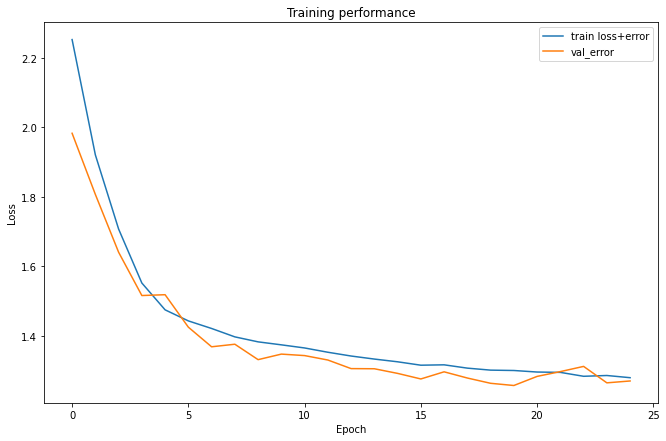

In [16]:
plt.figure(figsize = (11, 7))
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Plot confusion matrix

In [17]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap = plt.cm.Blues, labels = []):
#     plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

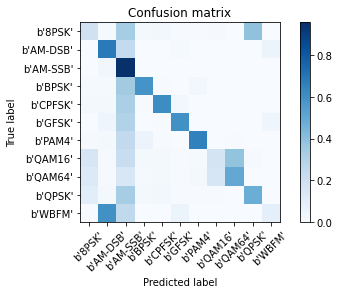

In [18]:
test_Y_hat = model.predict(X_test, batch_size = 1024)
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])

for i in range(0, X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
    
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
plot_confusion_matrix(confnorm, labels = classes)

## Get the test accuracy for different SNRs

In [19]:
def getTestAccArray(model, lbl, X_test, y_test, test_idx):
    acc = []
    
    snr_array=np.asarray(lbl)[:,1]
    lb_temp = preprocessing.LabelBinarizer()
    lb_temp.fit(snr_array)
    temp_array=lb_temp.classes_
    snr_label_array = []
    test_SNRs=snr_array[test_idx]

    snr_label_array.append(temp_array[6])
    snr_label_array.append(temp_array[4])
    snr_label_array.append(temp_array[3])
    snr_label_array.append(temp_array[2])
    snr_label_array.append(temp_array[1])
    snr_label_array.append(temp_array[0])
    snr_label_array.append(temp_array[9])
    snr_label_array.append(temp_array[8])
    snr_label_array.append(temp_array[7])
    snr_label_array.append(temp_array[5])
    snr_label_array.append(temp_array[10])
    snr_label_array.append(temp_array[16])
    snr_label_array.append(temp_array[17])
    snr_label_array.append(temp_array[18])
    snr_label_array.append(temp_array[19])
    snr_label_array.append(temp_array[11])
    snr_label_array.append(temp_array[12])
    snr_label_array.append(temp_array[13])
    snr_label_array.append(temp_array[14])
    snr_label_array.append(temp_array[15])

    for snr in snr_label_array:
#         test_SNRs = map(lambda x: lbl[x][1], test_idx)
        test_X_i = X_test[np.where(test_SNRs==snr)]
        test_Y_i = y_test[np.where(test_SNRs==snr)]

        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])
        
        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
            
        for i in range(0, len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        plt.figure()
        SNR_value = snr.astype('int')
        plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(SNR_value))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
#         acc[snr] = 1.0*cor/(cor+ncor)
        acc.append(1.0*cor/(cor+ncor))
        
    return acc

Overall Accuracy:  0.0908764367816092 for SNR b'-20'
Overall Accuracy:  0.09600292024091987 for SNR b'-18'
Overall Accuracy:  0.09700685178507032 for SNR b'-16'
Overall Accuracy:  0.1005852231163131 for SNR b'-14'
Overall Accuracy:  0.13065236818588025 for SNR b'-12'
Overall Accuracy:  0.1945926062166636 for SNR b'-10'
Overall Accuracy:  0.308801775147929 for SNR b'-8'
Overall Accuracy:  0.46117303124429015 for SNR b'-6'
Overall Accuracy:  0.6084618142703478 for SNR b'-4'
Overall Accuracy:  0.6968046477850399 for SNR b'-2'
Overall Accuracy:  0.74090407938258 for SNR b'0'
Overall Accuracy:  0.7265965166908563 for SNR b'2'
Overall Accuracy:  0.7200365965233303 for SNR b'4'
Overall Accuracy:  0.7305081636396992 for SNR b'6'
Overall Accuracy:  0.7348076231571378 for SNR b'8'
Overall Accuracy:  0.7227264637835914 for SNR b'10'
Overall Accuracy:  0.713817586018569 for SNR b'12'
Overall Accuracy:  0.7259326660600546 for SNR b'14'
Overall Accuracy:  0.7276207839562443 for SNR b'16'
Overall Acc

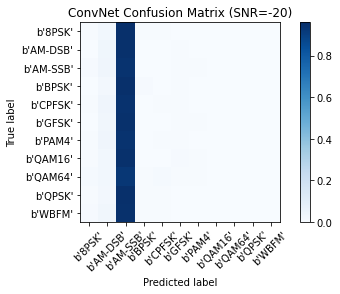

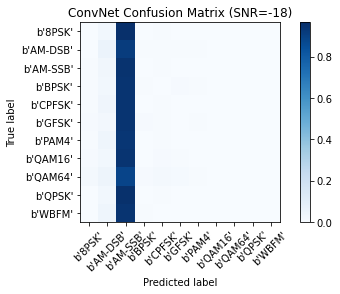

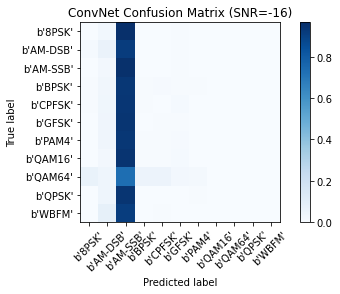

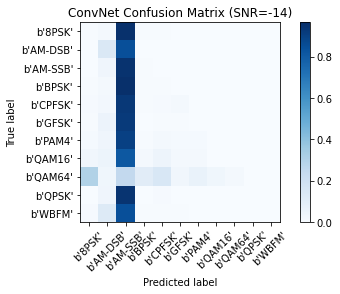

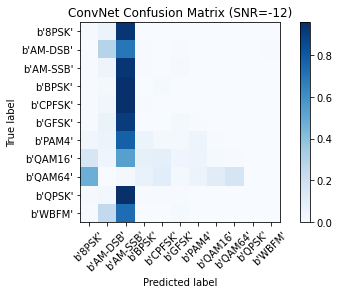

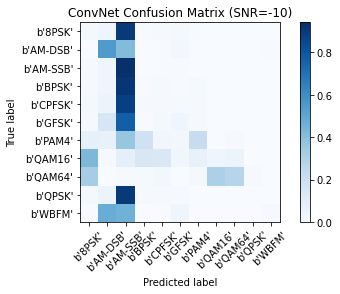

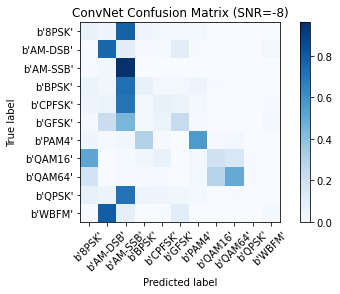

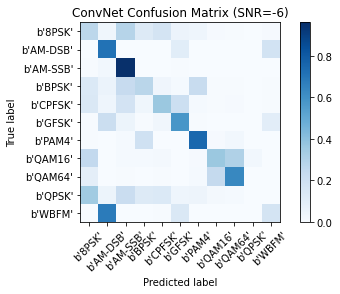

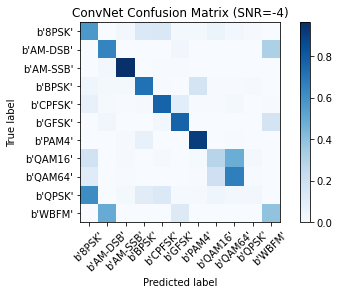

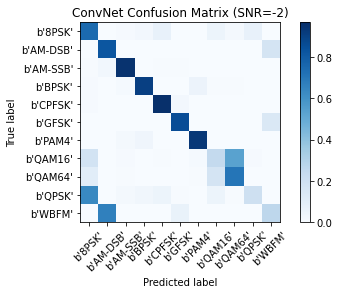

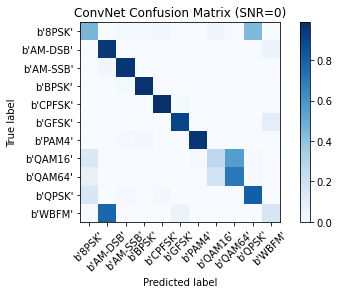

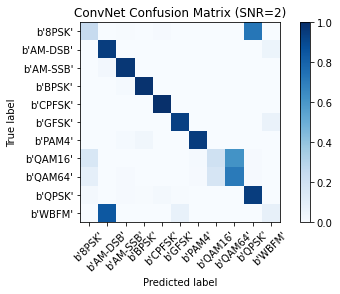

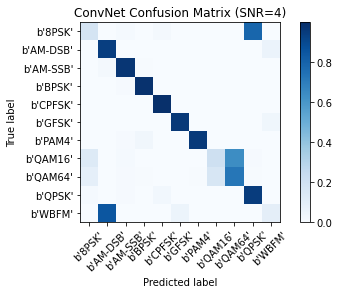

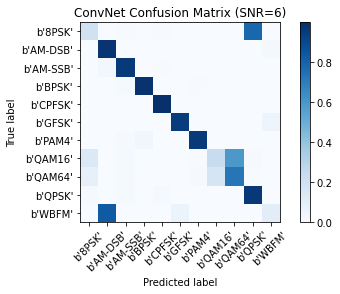

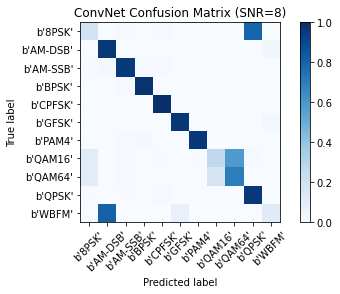

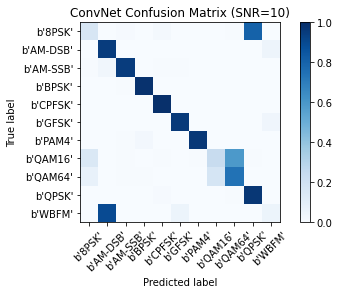

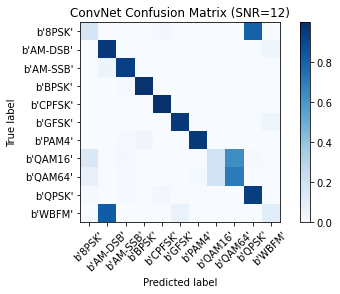

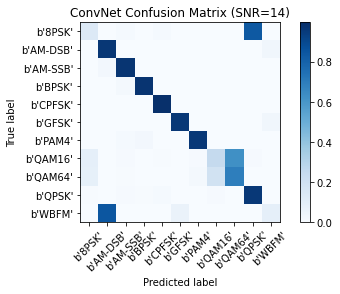

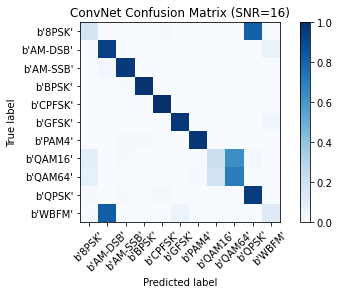

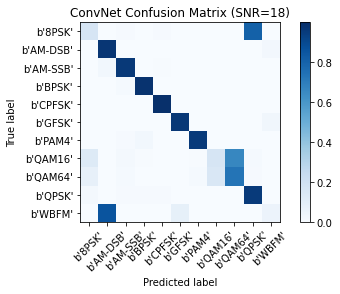

In [20]:
acc = getTestAccArray(model, lbl, X_test, y_test, test_idx)

Text(0.5, 1.0, 'Accuracy vs SNRs')

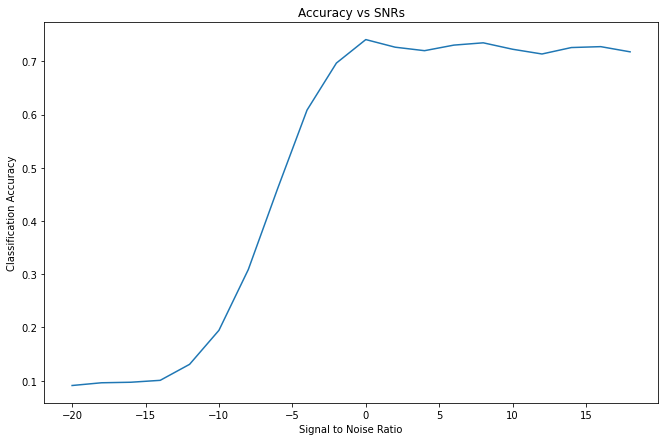

In [21]:
# Plot accuracy curve
plt.figure(figsize = (11, 7))
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title('Accuracy vs SNRs')